# 0 - Instalation of modules

In [ ]:
#Run this cell to have the progress bar
!pip install tqdm
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

# 1 - Importing modules

In [3]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# 2 - Get all files needed

In [4]:
data_folder = "../../Dataset/Movie/"

In [15]:
rating = pd.read_csv(f"{data_folder}ratings.csv").drop(["timestamp"], axis=1)
movie = pd.read_csv(f"{data_folder}movies.csv")

data = pd.merge(movie, rating, on="movieId")

# 3 - Transforming data

In [16]:
#Séparation en ligne du dataframe en petits dataframe
N = 1000
data_list = []
L = data.shape[0]

for i in range(1,N+1):
    debut = int((i-1)*L/N)
    fin = int(i*L/N)
    data_list.append(data.iloc[debut:fin, :])

In [17]:
#pivot table de chaque petits dataframe
pv_list = []
N = len(data_list)

i = 0
for d in tqdm(data_list):
    pv_list.append(d.pivot_table(index="userId", columns="title", values="rating", dropna=False))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
#Réunir tous les pivots tables selon le film
titles = data.title.unique()
dico = {title : [] for title in titles}

for pv in pv_list:
    for title in pv:
        dico[title].append(pv[title])

In [19]:
#Concatener tous les pivots tables selon leur film et on les gardes uniquement si ils ont pas trop d'éléments manquant.
all_df = []
keep_title = []
thresh = 0.3

i = 0
for title in tqdm(titles):
    tmp = pd.concat(dico[title], axis=0)
    if not (np.sum(tmp.isna(), axis=0) > tmp.shape[0]*thresh):
        all_df.append(tmp)
        keep_title.append(title)

  0%|          | 0/58958 [00:00<?, ?it/s]

In [ ]:
#On met tous les données dans un seul dataframe
userId_title_df = pd.DataFrame(index=np.sort(data.userId.unique()), columns=keep_title)

for df in tqdm(all_df):
    index = df.index
    values = df.values
    title = df.name

    for i in range(len(index)):
        userId_title_df.iloc[index[i]-1][title] = values[i]

userId_title_df.to_csv(f"{data_folder}userId_title_df.csv", sep=";")

In [194]:
del(userId_title_df)
#Si la dataframe a déjà été exporté, on peut le récupérer localement
if not ("userId_title_df" in locals()):
    userId_title_df = pd.read_csv(f"{data_folder}userId_title_df.csv", sep=";")

#On supprime les utilisateurs qui n'ont pas assez donnés de notes
userId_title_df = userId_title_df.dropna(axis=0, thresh=50).drop(userId_title_df.columns[0], axis=1)

# 4 - Colaborative filtering

In [195]:
#Standardisation des lignes pour supprimer les biais
def standardize(row):
    return row - np.mean(row)

userId_title_std = userId_title_df.apply(standardize, axis=1).fillna(0)
userId_title_std.shape

(16893, 131)

In [196]:
#Création de la matrice de cosinus distance
cos = cosine_similarity(userId_title_std)
cos_df = pd.DataFrame(cos, index=userId_title_std.index, columns=userId_title_std.index)

In [204]:
userId_title_df.head()

,Toy Story (1995),"American President, The (1995)",Sense and Sensibility (1995),Ace Ventura: When Nature Calls (1995),Get Shorty (1995),Seven (a.k.a. Se7en) (1995),"Usual Suspects, The (1995)",Die Hard: With a Vengeance (1995),Judge Dredd (1995),Dumb & Dumber (Dumb and Dumber) (1994),...,Kick-Ass (2010),Iron Man 2 (2010),Inception (2010),"King's Speech, The (2010)",Intouchables (2011),Gravity (2013),Interstellar (2014),Whiplash (2014),Star Wars: Episode VII - The Force Awakens (2015),Arrival (2016)
2,4.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,3.0,NaN,...,4.0,4.0,5.0,4.0,NaN,4.0,4.0,5.0,3.0,4.0
11,NaN,NaN,NaN,NaN,2.0,NaN,5.0,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,4.0,NaN,NaN,3.5,NaN,4.0,NaN,NaN,2.0,5.0,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,3.0,4.0,3.0,4.0,NaN,4.0,4.0,3.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,3.5,NaN,3.5,3.5,3.5,2.5,4.0,5.0,4.0,NaN


In [224]:
userId_title_df.index[2:]

Int64Index([    12,     17,     18,     30,     42,     69,     71,     74,
               154,    170,
            ...
            162480, 162483, 162494, 162507, 162511, 162515, 162518, 162520,
            162532, 162533],
           dtype='int64', length=16891)

In [226]:
#On garde les candidats similaire et complétement opposé
eps = 0.8
cluster = {}
L = len(cos_df)

i = 1
for user1 in tqdm(userId_title_df.index):
    cluster[user1] = {"+" : [], "-" : []}

    for user2 in userId_title_df.index[i:]:
        tmp = cos_df.loc[user1, user2]

        if (tmp >= eps):
            cluster[user1]["+"].append(user2)
        elif (tmp <= -eps):
            cluster[user1]["-"].append(user2)

    i += 1

  0%|          | 0/16893 [00:00<?, ?it/s]

In [207]:
#On devine la note en fonction des candidtats similaires
def guess_rate_cluster(user, title):
    rate = 0
    coeff = 0

    for u in cluster[user]["+"]:
        if not (pd.isnull(userId_title_df.loc[u, title])):
            rate += cos_df.loc[user, u]*userId_title_df.loc[u, title]
            coeff += cos_df.loc[user, u]

    if (coeff == 0):
        return 2.5
    else:   
        return rate/coeff

In [209]:
#On devine la note en fonction de tous les candidats
def guess_rate_all(user, title):
    rate = 0
    coef = 0

    for i in userId_title_df.index():
        if (i != user) and not (pd.isnull(userId_title_df.loc[i, title])):
            rate += cos_df.loc[user, i]*userId_title_df.loc[i, title]
            coef += cos_df.loc[user, i]

    if (coef == 0):
            return 2.5
    else:   
        return rate/coef

In [175]:
#On compare les deux méthodes
from time import time

user = 2
titles = userId_title_df.columns

deltaT = []
t_cluster = []
t_all = []
positif = 0

deltaN = []
n_cluster = []
n_all = []
sup = 0

for title in tqdm(titles):
    start = time()
    n_cluster.append(guess_rate_cluster(user, title))
    t_cluster.append(time() - start)

    start = time()
    n_all.append(guess_rate_all(user, title))
    t_all.append(time() - start)
    
    dN = n_cluster[-1]-n_all[-1]
    deltaN.append(np.abs(dN))
    sup += 1 if (dN > 0) else 0 

    dT = t_all[-1]-t_cluster[-1]
    deltaT.append(np.abs(dT))
    positif += 1 if (dT > 0) else 0

  0%|          | 0/131 [00:00<?, ?it/s]

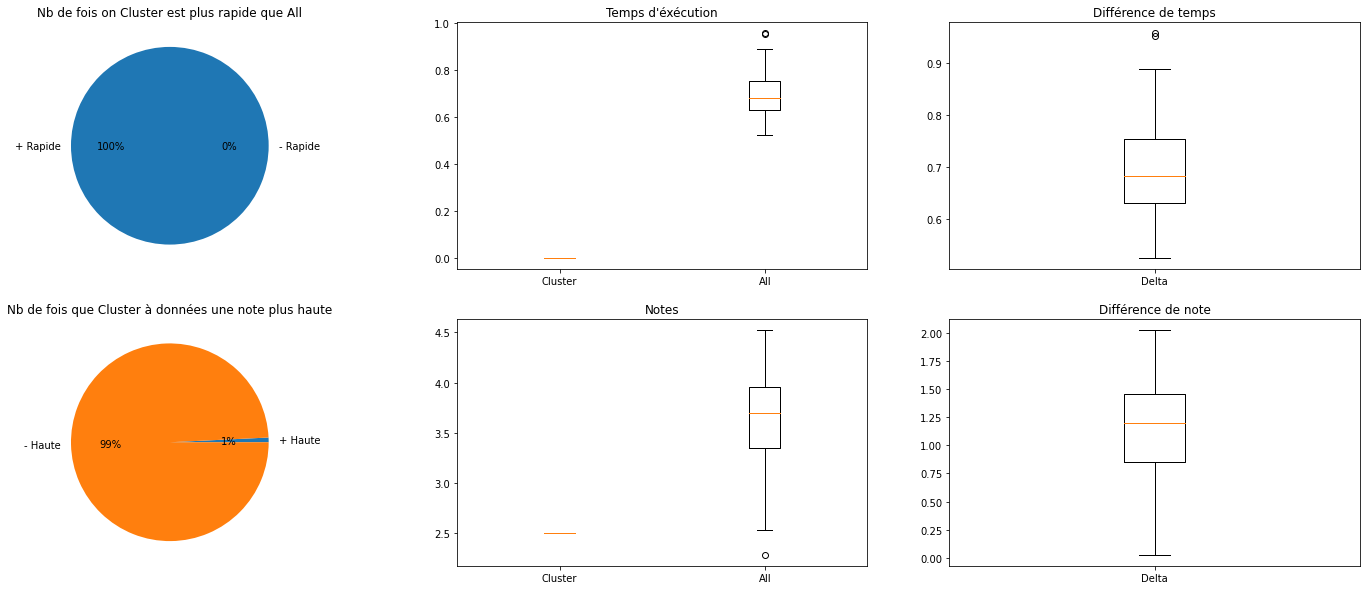

In [179]:
#On affiche graphiquement le comparatif
plt.figure(figsize=(25,10))

j = 0
plots_pie = [[positif, len(t_cluster)-positif], [sup, len(n_cluster)-sup]]
labels_pie = [["+ Rapide", "- Rapide"], ["+ Haute", "- Haute"]]
titles_pie = ["Nb de fois on Cluster est plus rapide que All", "Nb de fois que Cluster à données une note plus haute"]

k = 0
plots_box = [[t_cluster, t_all], deltaT, [n_cluster, n_all], deltaN]
labels_box = [["Cluster", "All"], ["Delta"], ["Cluster", "All"], ["Delta"]]
titles_box = ["Temps d'éxécution", "Différence de temps", "Notes", "Différence de note"]

for i in range(6):
    plt.subplot(2, 3, i+1)

    if i+1 in [1, 4]:
        plt.pie(plots_pie[j], labels=labels_pie[j], autopct='%.0f%%')
        plt.title(titles_pie[j])
        j += 1
    else:
        plt.boxplot(plots_box[k], labels=labels_box[k])
        plt.title(titles_box[k])
        k += 1

plt.show()

In [169]:
users = userId_title_df.index[:1]

n_cluster = []
n_all = []
delta = []
n_true = []

for user in tqdm(users):
    all_rated_film = userId_title_df.loc[user].dropna(axis=0)
    n_true += all_rated_film.values.tolist()
    
    for movie in tqdm(all_rated_film.index):
        clust = guess_rate_cluster(user, movie)
        all = guess_rate_all(user, movie)

        delta.append(np.abs(all-clust))
        n_cluster.append(clust)
        n_all.append(all)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

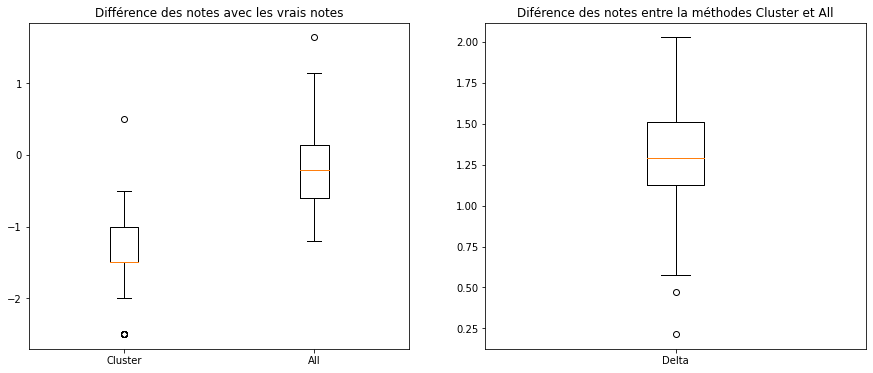

In [174]:
delta_cluster = []
delta_all = []
for i in range(len(n_true)):
    delta_cluster.append(n_cluster[i]-n_true[i])
    delta_all.append(n_all[i]-n_true[i])

plots = [[delta_cluster, delta_all], delta]
labels = [["Cluster", "All"], ["Delta"]]
titles = ["Différence des notes avec les vrais notes", "Diférence des notes entre la méthodes Cluster et All"]

plt.figure(figsize=(15,6))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.boxplot(plots[i], labels=labels[i])
    plt.title(titles[i])

plt.show()

In [142]:
userId_title_df.iloc[2].dropna(axis=0).sort_values(ascending=0)

American Beauty (1999)                              5.0
Usual Suspects, The (1995)                          5.0
Kill Bill: Vol. 1 (2003)                            5.0
Pulp Fiction (1994)                                 5.0
Shawshank Redemption, The (1994)                    5.0
                                                   ... 
Face/Off (1997)                                     3.0
Star Trek: First Contact (1996)                     3.0
Pan's Labyrinth (Laberinto del fauno, El) (2006)    3.0
Harry Potter and the Chamber of Secrets (2002)      2.5
Full Monty, The (1997)                              2.5
Name: 42, Length: 63, dtype: float64

In [157]:
movies = userId_title_df.columns
user = 2
rates = []

for movie in tqdm(movies):
    rates.append(guess_rate_cluster(user, movie))

ndf = pd.DataFrame(index=movies, columns=["rates"])
ndf["rates"] = rates

  0%|          | 0/131 [00:00<?, ?it/s]

In [158]:
ndf["rates"].sort_values(ascending=0)

Toy Story (1995)                                                 2.5
Pirates of the Caribbean: The Curse of the Black Pearl (2003)    2.5
Bruce Almighty (2003)                                            2.5
Matrix Reloaded, The (2003)                                      2.5
Lord of the Rings: The Two Towers, The (2002)                    2.5
                                                                ... 
Mary Poppins (1964)                                              2.5
It's a Wonderful Life (1946)                                     2.5
Vertigo (1958)                                                   2.5
Godfather, The (1972)                                            2.5
Arrival (2016)                                                   2.5
Name: rates, Length: 131, dtype: float64